In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import keras
from IPython.display import Image,display
from keras.applications.vgg19 import VGG19
from processfuncs import *

In [2]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)

    
    return J_content

In [3]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    
    GA = tf.matmul(A,tf.transpose(A))
    
    
    return GA

In [4]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
   
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_S.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(tf.transpose(a_S,perm=[0,3,1,2]),shape=[n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),shape=[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*n_C*n_C*n_H*n_H*n_W*n_W)
    
       
    return J_style_layer

In [7]:
content_image_path = "./images/gimage.png"
style_image_path = "./images/simage.jpg"
#Obtaining dimensions of content image
width,height = keras.preprocessing.image.load_img(content_image_path).size
#Fixing dimensions for generated image
nrows = 400
ncols = int(width*nrows/height)


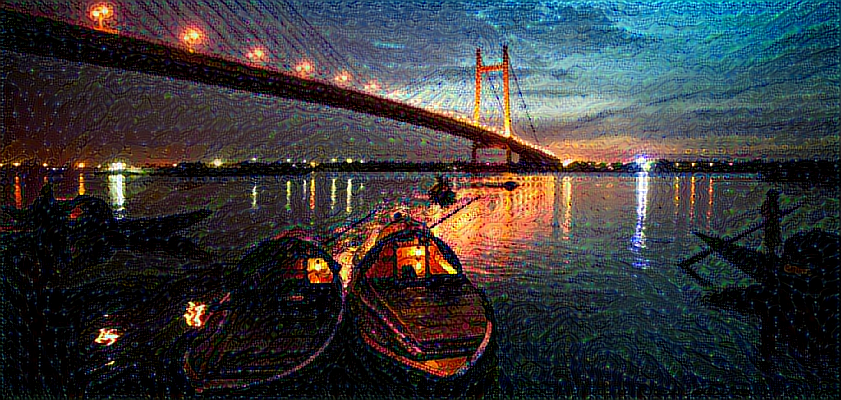

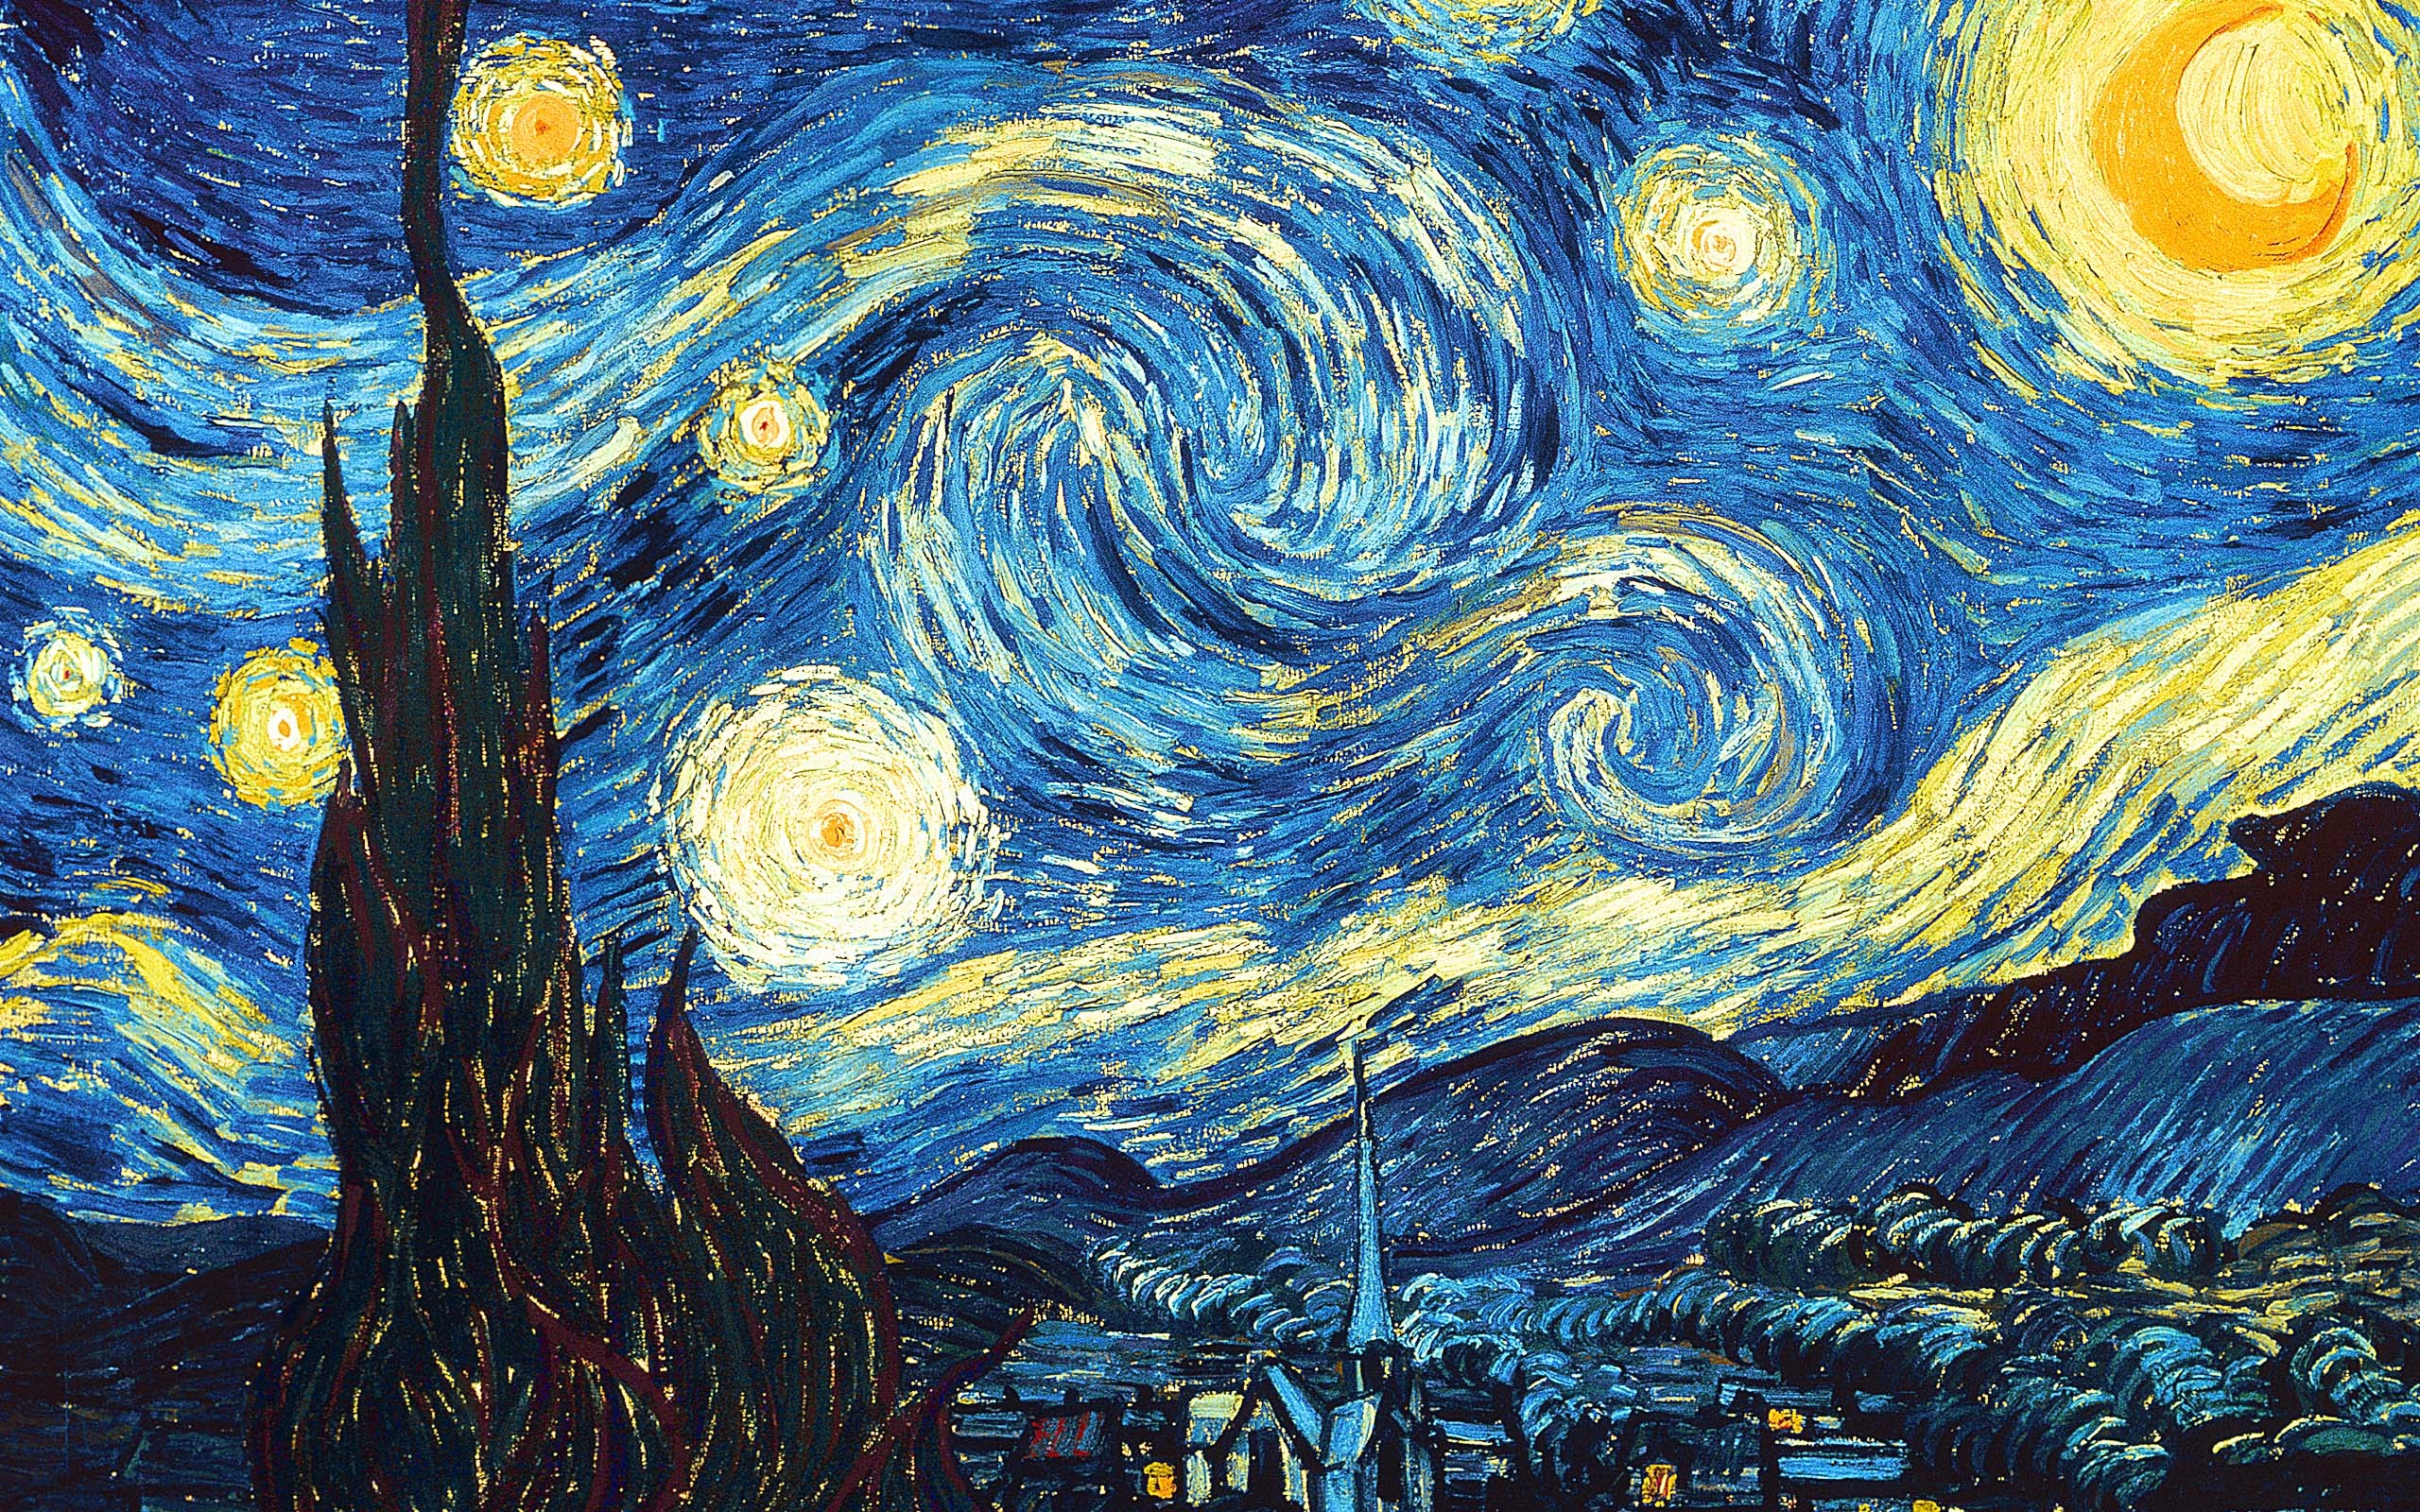

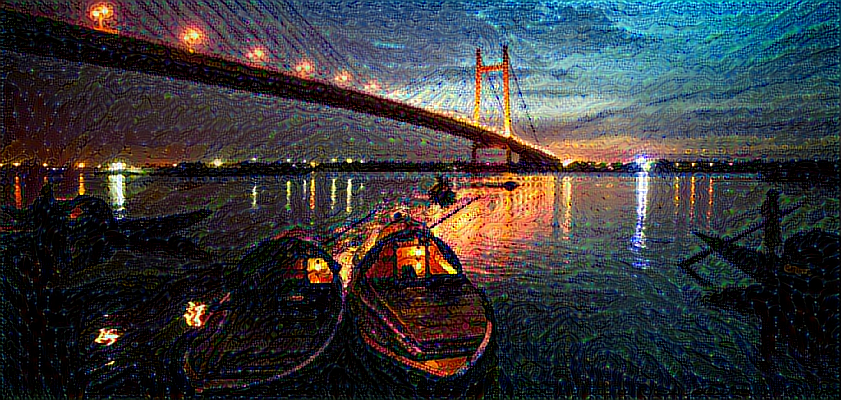

In [8]:
display(Image(content_image_path))
display(Image(style_image_path))
display(Image("./images/genimg.png"))

In [9]:
#Loading VGGNet19
funmodel = VGG19(input_shape=(224,224,3),include_top=False,weights='imagenet')
funmodel.trainable = False
funmodel.summary()



Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
#Dictionary to store layer outputs associated with layer names of VGGNet19
out_dict = dict([(layer.name,layer.output) for layer in funmodel.layers])
#Keras model using out_dict to obtain style and content activations from VGGNet19 
feature_extractor = keras.Model(inputs = funmodel.inputs,outputs = out_dict)

In [10]:
style_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]
content_layer = 'block4_conv2'

In [5]:
def cost_function(cimage,gimage,simage,alpha = 2.5e-8, beta = 1e-6):
    input_tensor = tf.concat([cimage,simage,gimage],axis=0)
    #Extract all layer activations of VGGNet19 on content, style and present generated image respectively
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer]
    cimage_features = layer_features[0,:,:,:]
    gimage_features = layer_features[2,:,:,:]
    #Make arrays 4 dimensional as functions require 4 dimensional input
    cimage_features = tf.expand_dims(cimage_features,axis=0)
    gimage_features = tf.expand_dims(gimage_features,axis=0)
    #Calculating content loss
    loss = loss + alpha * compute_content_cost(cimage_features,gimage_features)
    
    #Calculating style loss
    for layer in style_layers:
        layer_name,weight = layer
        layer_features = features[layer_name]
        simage_features = layer_features[1,:,:,:]
        gimage_features = layer_features[2,:,:,:]
        simage_features = tf.expand_dims(simage_features,axis=0)
        gimage_features = tf.expand_dims(gimage_features,axis=0)
        loss = loss + beta*weight*compute_layer_style_cost(simage_features,gimage_features)
    
        
    return loss
    

In [6]:
def compute_loss_grads(cimage,simage,gimage):
    #GradientTape "watches" loss function
    with tf.GradientTape() as diff:
        loss = cost_function(cimage,gimage,simage)
    #Obtaining gradients on Loss function 
    grads = diff.gradient(loss,gimage)
    return loss, grads
    

In [12]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)
genimg_path = "./images/genimg.png"
result_prefix="./images/genimg"
#Images preprocessed for passing into ConvNet
content_image = preprocess_image(content_image_path,nrows,ncols)
style_image = preprocess_image(style_image_path,nrows,ncols)
#The content image used as base for generated image
gen_image = tf.Variable(preprocess_image(genimg_path,nrows,ncols))
iterations = 4000
#Minimizing Loss
for i in range(1,iterations + 1):
    loss,grads = compute_loss_grads(content_image,style_image,gen_image)
    optimizer.apply_gradients([(grads,gen_image)])
    if i%100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(gen_image.numpy(),nrows,ncols)
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
    
display(Image(result_prefix + "_at_iteration_1300.png"))



Iteration 1: loss=1033.33


KeyboardInterrupt: 